In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import re
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zomato-bangalore-restaurants/zomato.csv


In [63]:
df = pd.read_csv("../input/zomato-bangalore-restaurants/zomato.csv")
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [64]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [66]:
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


In [67]:
df["reviews_list"]

0        [('Rated 4.0', 'RATED\n  A beautiful place to ...
1        [('Rated 4.0', 'RATED\n  Had been here for din...
2        [('Rated 3.0', "RATED\n  Ambience is not that ...
3        [('Rated 4.0', "RATED\n  Great food and proper...
4        [('Rated 4.0', 'RATED\n  Very good restaurant ...
                               ...                        
51712    [('Rated 5.0', "RATED\n  Food and service are ...
51713                                                   []
51714                                                   []
51715    [('Rated 4.0', 'RATED\n  Nice and friendly pla...
51716    [('Rated 5.0', 'RATED\n  Great ambience , look...
Name: reviews_list, Length: 51717, dtype: object

In [68]:
zomato_df = df.drop(["phone", "dish_liked", "url"], axis = 1)
zomato_df.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


<Axes: xlabel='online_order'>

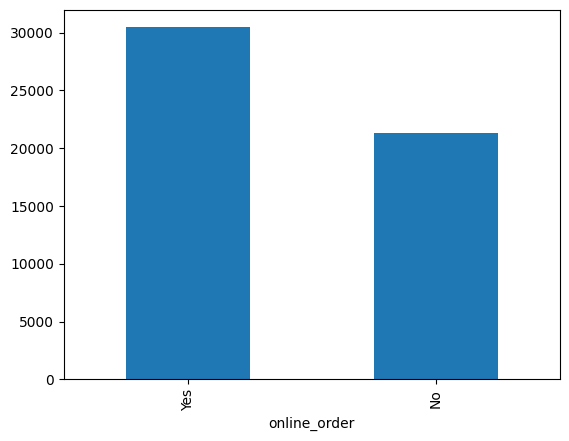

In [69]:
zomato_df["online_order"].value_counts().plot(kind="bar")

<Axes: xlabel='book_table'>

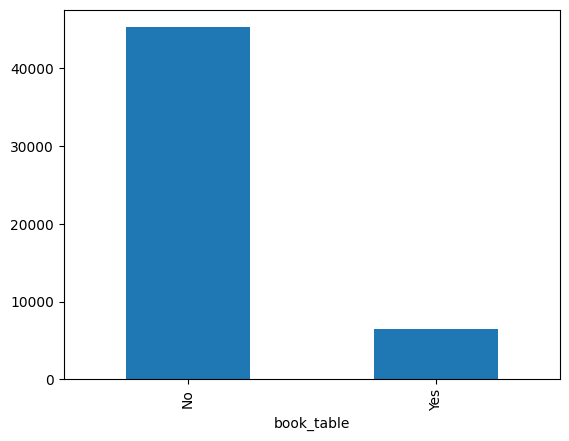

In [70]:
zomato_df["book_table"].value_counts().plot(kind="bar")

In [71]:
zomato_df.loc[(zomato_df["online_order"]=="Yes") & (zomato_df["book_table"]=="No")]["name"].count()

26639

In [72]:
zomato_df.loc[(zomato_df["online_order"]=="Yes") & (zomato_df["book_table"]=="Yes")]["name"].count()

3805

In [73]:
zomato_df.loc[(zomato_df["online_order"]=="No") & (zomato_df["book_table"]=="No")]["name"].count()

18629

In [74]:
zomato_df.loc[(zomato_df["online_order"]=="No") & (zomato_df["book_table"]=="Yes")]["name"].count()

2644

## Price Range of restaurants

In [75]:
remove_comma = lambda x : int(x.replace(',', '')) if type(x)== str and x != np.nan else x
zomato_df.votes = zomato_df.votes.astype('int')
zomato_df["approx_cost(for two people)"] = zomato_df["approx_cost(for two people)"].apply(remove_comma)
zomato_df

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6 /5,27,Whitefield,Bar,Continental,1500.0,"[('Rated 5.0', ""RATED\n Food and service are ...",[],Pubs and bars,Whitefield
51713,"Number 10, Garudachar Palya, Mahadevapura, Whi...",Vinod Bar And Restaurant,No,No,NaN,0,Whitefield,Bar,Finger Food,600.0,[],[],Pubs and bars,Whitefield
51714,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Plunge - Sheraton Grand Bengaluru Whitefield H...,No,No,NaN,0,Whitefield,Bar,Finger Food,2000.0,[],[],Pubs and bars,Whitefield
51715,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3 /5,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500.0,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",[],Pubs and bars,Whitefield


In [76]:
zomato_df["approx_cost(for two people)"].value_counts()[:]

approx_cost(for two people)
300.0     7576
400.0     6562
500.0     4980
200.0     4857
600.0     3714
          ... 
60.0         1
5000.0       1
3700.0       1
469.0        1
160.0        1
Name: count, Length: 70, dtype: int64

In [77]:
zomato_df["approx_cost(for two people)"].value_counts()

approx_cost(for two people)
300.0     7576
400.0     6562
500.0     4980
200.0     4857
600.0     3714
          ... 
60.0         1
5000.0       1
3700.0       1
469.0        1
160.0        1
Name: count, Length: 70, dtype: int64

In [78]:
zomato_df.loc[zomato_df["approx_cost(for two people)"]==160]

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
853,"T.R., Mill Circle, Basavanagudi, Bangalore",Ambur Dum Biriyani,No,No,NEW,0,Basavanagudi,Quick Bites,Biryani,160.0,[],[],Dine-out,Banashankari


In [79]:
zomato_df["listed_in(city)"].value_counts()

listed_in(city)
BTM                      3279
Koramangala 7th Block    2938
Koramangala 5th Block    2836
Koramangala 4th Block    2779
Koramangala 6th Block    2623
Jayanagar                2371
JP Nagar                 2096
Indiranagar              1860
Church Street            1827
MG Road                  1811
Brigade Road             1769
Lavelle Road             1744
HSR                      1741
Marathahalli             1659
Residency Road           1620
Whitefield               1620
Bannerghatta Road        1617
Brookefield              1518
Old Airport Road         1425
Kammanahalli             1329
Kalyan Nagar             1309
Basavanagudi             1266
Sarjapur Road            1261
Electronic City          1229
Bellandur                1227
Frazer Town              1185
Malleshwaram             1096
Rajajinagar              1079
Banashankari              863
New BEL Road              740
Name: count, dtype: int64

In [80]:
zomato_df["approx_cost(for two people)"].value_counts()[::-1]

approx_cost(for two people)
160.0        1
469.0        1
3700.0       1
5000.0       1
60.0         1
          ... 
600.0     3714
200.0     4857
500.0     4980
400.0     6562
300.0     7576
Name: count, Length: 70, dtype: int64

<Axes: xlabel='listed_in(type)'>

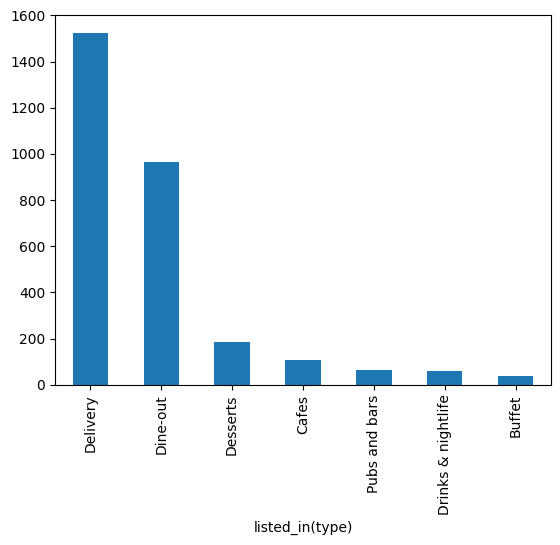

In [81]:
Koramangala_7th_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Koramangala 7th Block"]["listed_in(type)"].value_counts().plot(kind="bar")
Koramangala_7th_restaurants

<Axes: xlabel='listed_in(type)'>

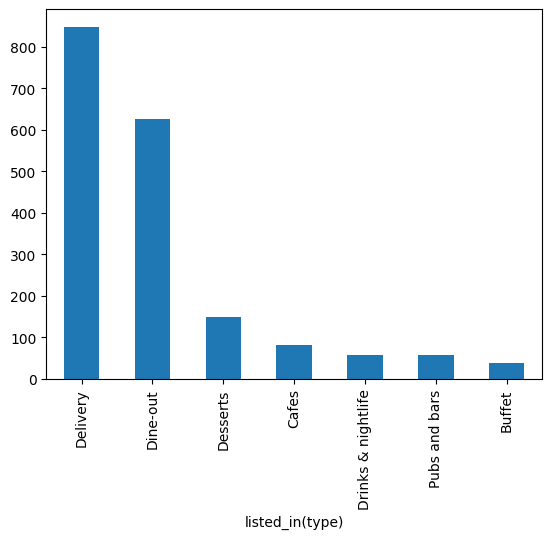

In [82]:
indiranagar_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Indiranagar"]["listed_in(type)"].value_counts().plot(kind="bar")
indiranagar_restaurants

<Axes: xlabel='listed_in(type)'>

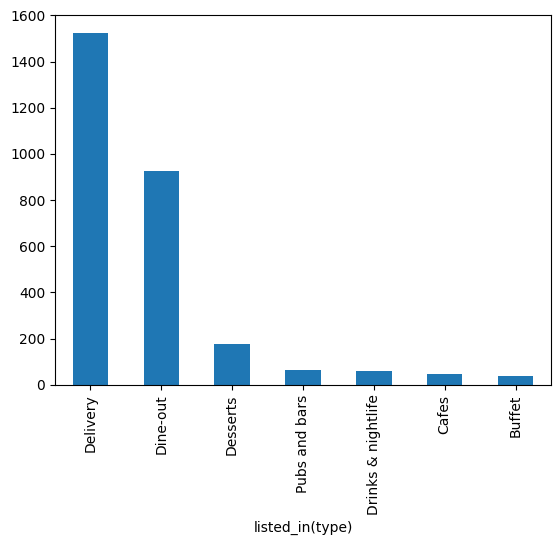

In [83]:
Koramangala_5th_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Koramangala 5th Block"]["listed_in(type)"].value_counts().plot(kind="bar")
Koramangala_5th_restaurants

<Axes: xlabel='listed_in(type)'>

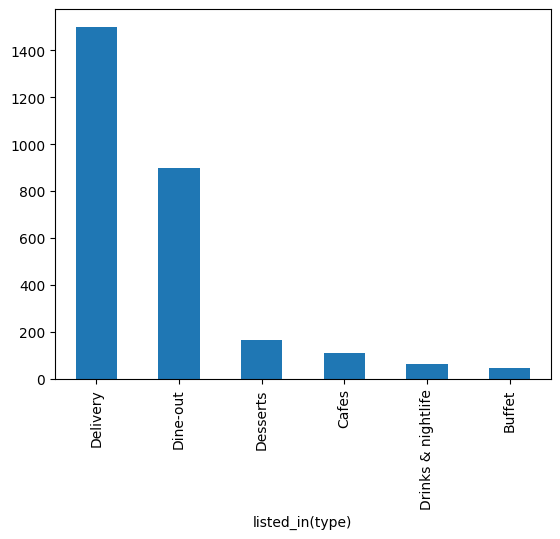

In [84]:
Koramangala_4th_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Koramangala 4th Block"]["listed_in(type)"].value_counts().plot(kind="bar")
Koramangala_4th_restaurants

<Axes: xlabel='listed_in(type)'>

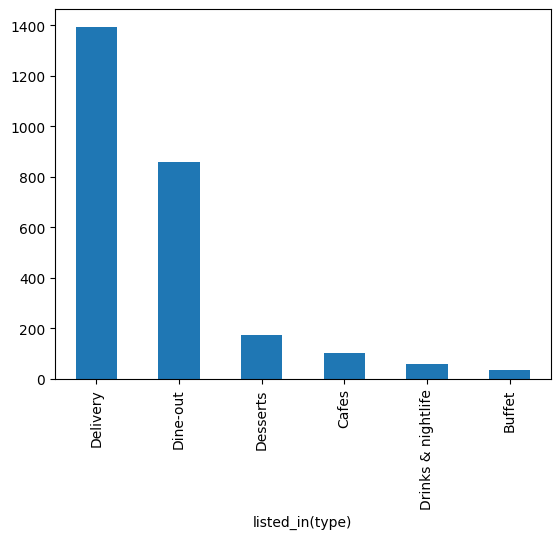

In [85]:
Koramangala_6th_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Koramangala 6th Block"]["listed_in(type)"].value_counts().plot(kind="bar")
Koramangala_6th_restaurants

<Axes: xlabel='listed_in(type)'>

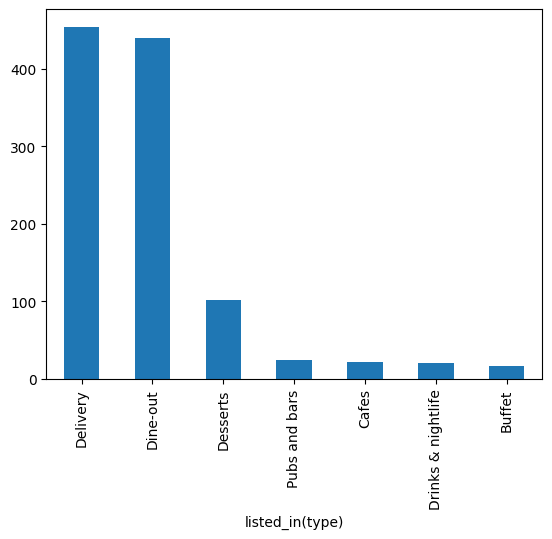

In [86]:
Rajajinagar_restaurants = zomato_df.loc[zomato_df["listed_in(city)"]=="Rajajinagar"]["listed_in(type)"].value_counts().plot(kind="bar")
Rajajinagar_restaurants

In [87]:
pub_sentiment_df = zomato_df.loc[zomato_df["listed_in(type)"]=="Pubs and bars"]

In [88]:
# dataa = pub_sentiment_df["reviews_list"][4956]
# remove_RATED = re.sub("RATED", "", dataa)
# n_to_n = re.sub("\n","\n", remove_RATED)
# # remove_newline = re.sub("\n","", n_to_n)
# n_to_n
# # remove_Rated=re.sub("Rated", "", remove_newline)
# # remove_Rated

In [89]:
dataa = pub_sentiment_df["reviews_list"][4956]
                  

In [90]:
data = pd.DataFrame(eval(dataa), columns = ["Rating", "Review"])
data

,Rating,Review
0,Rated 4.0,RATED\n Great place to hang out with friends....
1,Rated 5.0,RATED\n This place has amazing ambiance and t...
2,Rated 4.0,RATED\n The place is very nice with a rooftop...
3,Rated 5.0,RATED\n We are really impressed with the gest...
4,Rated 5.0,RATED\n Vapour Brewpub and Diner\n\nI went he...
...,...,...
285,Rated 4.0,"RATED\n If you're a 90s kid, you'll love the ..."
286,Rated 2.0,RATED\n Very slow service and waiter making f...
287,Rated 5.0,"RATED\n Great atmosphere, nice ambiance, yumm..."
288,Rated 4.0,RATED\n Even though they had an amazing sprea...


In [91]:
# def clean_text(text):
#     text = re.sub(r"RATED\n", "", text)
#     text = re.sub(r"[^\w\s]", "", text)
#     text = re.sub(f"Ãx83Ãx83Ãx82Ãx82Ãx83Ãx82Ãx82Ãx92","'",text)
# #     text = re.sub(r"[^a-zA-Z]", "", text)
# #     text = text.lower()
#     text = re.sub(r"RATEDn","", text)
#     return text
# data = clean_text(str(dataa))
# data = pd.DataFrame(eval(data), columns = ['Ratings', 'Review'])
# data

In [92]:
zomato_df = zomato_df.rename(columns = {"approx_cost(for two people)" : "cost", "listed_in(type)":"type", "listed_in(city)":"city"})
zomato_df.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [93]:
zomato_df["cost"] = zomato_df["cost"].astype(str)
zomato_df["cost"] = zomato_df["cost"].apply(lambda x: x.replace(",", "."))
zomato_df["cost"] = zomato_df["cost"].astype(float)
zomato_df["cost"].head()

0    800.0
1    800.0
2    800.0
3    300.0
4    600.0
Name: cost, dtype: float64

In [94]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       51717 non-null  object 
 1   name          51717 non-null  object 
 2   online_order  51717 non-null  object 
 3   book_table    51717 non-null  object 
 4   rate          43942 non-null  object 
 5   votes         51717 non-null  int64  
 6   location      51696 non-null  object 
 7   rest_type     51490 non-null  object 
 8   cuisines      51672 non-null  object 
 9   cost          51371 non-null  float64
 10  reviews_list  51717 non-null  object 
 11  menu_item     51717 non-null  object 
 12  type          51717 non-null  object 
 13  city          51717 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.5+ MB


In [95]:
zomato_df.duplicated().sum()
zomato_df.drop_duplicates(inplace=True)

In [96]:
zomato_df.isnull().sum()
zomato_df.dropna(how="any", inplace = True)
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       43499 non-null  object 
 1   name          43499 non-null  object 
 2   online_order  43499 non-null  object 
 3   book_table    43499 non-null  object 
 4   rate          43499 non-null  object 
 5   votes         43499 non-null  int64  
 6   location      43499 non-null  object 
 7   rest_type     43499 non-null  object 
 8   cuisines      43499 non-null  object 
 9   cost          43499 non-null  float64
 10  reviews_list  43499 non-null  object 
 11  menu_item     43499 non-null  object 
 12  type          43499 non-null  object 
 13  city          43499 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.0+ MB


In [97]:
zomato_df["rate"]
zomato_df = zomato_df.loc[zomato_df.rate != "NEW"]
zomato_df = zomato_df.loc[zomato_df.rate != "-"].reset_index(drop=True)
remove_slash = lambda x: x.replace("/5", "") if type(x) == str else x
zomato_df.rate = zomato_df.rate.apply(remove_slash).str.strip().astype("float")
zomato_df["rate"].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [98]:
df = zomato_df.copy()
df

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41232,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800.0,"[('Rated 4.0', 'RATED\n Ambience- Big and spa...",[],Pubs and bars,Whitefield
41233,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800.0,"[('Rated 4.0', 'RATED\n A fine place to chill...",[],Pubs and bars,Whitefield
41234,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,Continental,1500.0,"[('Rated 5.0', ""RATED\n Food and service are ...",[],Pubs and bars,Whitefield
41235,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500.0,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",[],Pubs and bars,Whitefield


In [99]:
all_ratings = []
for ratings in tqdm(df["reviews_list"]):
    ratings = eval(ratings)
    
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip("RATED").strip()
            
            score = float(score)
            all_ratings.append([score, doc])

100%|██████████| 41237/41237 [00:22<00:00, 1803.30it/s]


In [100]:
ratings_df = pd.DataFrame(all_ratings, columns = ["score", "doc"])
print(ratings_df.shape)
ratings_df.head()

(1295849, 2)


,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


In [101]:
docs_with_ratings = []
for doc in ratings_df["doc"][:150]:
    if "/" in doc:
        print(doc)
        docs_with_ratings.append(doc)

Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5
I was looking for a quite place to spend some time with family and as well wanted to try some new place. Since I was at Banashankari I thought of trying this place. The place had good rating and was part of Zomato gold. So I decided to try this place. It was a delite to see a very friendly staff and food we ordered was very tasty as well.

Food : 4/5
Ambience :3/5
Friendly staff : 4/5
Pocket friendly : 4/5

Will definitely visit again ??
Food: 8/10
Ambience:8/10
Staff:8/10
One of the good places to try north Indian food...but depends on ur taste buds. Not everyone will like all the items here. Specially when u r particular abt sweet and spicy food.
There's buffet available too.
We had ordered paneer uttar dakshin and paneer kurchan..was amazing. The Gobi hara pyaz and mix veg were average.
One of

In [102]:
for docs in docs_with_ratings:
    x = re.findall("[0-9.]*[0-9]/[0-9]*[0-9]", docs)
    print(x)

['5/5', '5/5', '5/5', '5/5']
['4/5', '3/5', '4/5', '4/5']
['8/10', '8/10', '8/10']
['6/10', '7/10', '8/10', '7.5/10']
[]
[]
[]
[]
['4/5', '3.5/5', '4/5', '4/5']
['3/5', '3/5', '3/5']
['10/10', '10/10', '10/10', '25/10']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4.5/5', '4/5', '4.5/5', '4.5/5']
['3.5/5', '4/5', '3.5/5']
['3.5/5', '4/5', '3.5/5']


In [103]:
doc = docs_with_ratings[0]
subbed_doc = re.sub("[0-9.]*[0-9]/[0-9]*[0-9]", "score", doc)
print("\nSUBBED")
print(subbed_doc)


SUBBED
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : score
Service : score
Ambience :score
Overall :score


In [104]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


In [105]:
ratings_df["reviews"] = ratings_df["doc"].str.lower()


In [106]:
import string
punct_to_remove = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punct_to_remove))

ratings_df["reviews"] = ratings_df["reviews"].apply(lambda text: remove_punctuation(text))

In [107]:
ratings_df = ratings_df.drop(["doc"], axis = 1)

In [108]:
from nltk.corpus import stopwords
stpwrds = set(stopwords.words("english"))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stpwrds])

ratings_df["reviews"] = ratings_df["reviews"].apply(lambda text: remove_stopwords(text))
ratings_df.sample(3)

,score,reviews
74146,5.0,amazing place visit whether friends family def...
466376,1.0,said boiled rice got normal rice booked boiled...
1255640,4.5,best place ordering cake never tried anything ...


In [109]:
def remove_urls(text):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    return url_pattern.sub(r"", text)

ratings_df["reviews"] = ratings_df["reviews"].apply(lambda text: remove_urls(text))
ratings_df.sample(3)

,score,reviews
721612,4.0,really cool place eat hangout crowded weekends...
582686,4.0,frequent visitor leelas kitchen decent price g...
221002,4.0,cheesecake must time favourite sprouts salad n...


In [110]:
ratings_df["score"].astype("category").value_counts()

score
4.0    397337
5.0    372425
3.0    178102
1.0    149367
2.0     65870
3.5     55691
4.5     50292
2.5     17432
1.5      9333
Name: count, dtype: int64

In [111]:
def remove_shit(text):
    shit = re.compile(r"ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x83ã\x83\x83ã\x82\x82ã\x83\x82ã\x82â°ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x9fã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x98ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x98ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x83ã\x83\x83ã\x82\x82ã\x83\x82ã\x82â°ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x9fã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x98ã\x83\x83ã\x82\x83ã\x83\x82ã\x82\x82ã\x83\x83ã\x82\x82ã\x83\x82ã\x82\x98")
    return shit.sub("",text)

ratings_df["reviews"] = ratings_df["reviews"].apply([lambda text: remove_shit(text)])
ratings_df.sample(5)

,score,reviews
660151,4.0,amazing ambience well thought infrastructure s...
200490,4.5,visting place 5yrs moved another city nothing ...
399944,4.0,juicy name suggests juice stall long menu juic...
1056815,5.0,delicious homely food perfect flavor one must ...
345544,4.5,original hyderabadi dum biryani feels like hom...


In [112]:
ratings_df["score"].value_counts()

score
4.0    397337
5.0    372425
3.0    178102
1.0    149367
2.0     65870
3.5     55691
4.5     50292
2.5     17432
1.5      9333
Name: count, dtype: int64

In [113]:
X = ratings_df["reviews"].values
Y = ratings_df["score"].values

In [114]:
encoder = LabelEncoder()
encoded_y = encoder.fit(Y)

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=2)

In [116]:
print(X_train.shape, X_test.shape)

(1036679,) (259170,)


In [117]:
vectorizer = TfidfVectorizer()

In [118]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [119]:
print(X_train)

  (0, 54036)	0.05032010749443493
  (0, 18301)	0.11753251767811788
  (0, 52649)	0.09459962956355204
  (0, 36288)	0.1140722574260384
  (0, 74165)	0.1480322503448196
  (0, 9246)	0.11548076139855751
  (0, 87618)	0.0841928954523347
  (0, 72120)	0.153258908247572
  (0, 86334)	0.11846125769869216
  (0, 7405)	0.08399481832988168
  (0, 63011)	0.08722566631047772
  (0, 85184)	0.15427299204919412
  (0, 36433)	0.08488701701131167
  (0, 48096)	0.07057276241040851
  (0, 77488)	0.2609142519491831
  (0, 72423)	0.13339172203100214
  (0, 86522)	0.08886902750897863
  (0, 30824)	0.07201043153849705
  (0, 85294)	0.09438617588455493
  (0, 30780)	0.16739544481320356
  (0, 85314)	0.09384034962701526
  (0, 20964)	0.06778813264750164
  (0, 7774)	0.14780051414071266
  (0, 49098)	0.12927283898822783
  (0, 80343)	0.10562646392359357
  :	:
  (1036678, 67498)	0.10579633326901304
  (1036678, 30532)	0.12708431637913825
  (1036678, 88394)	0.1806947667076748
  (1036678, 37374)	0.12519944409579967
  (1036678, 8690)	0.109

In [121]:
model = LinearRegression()

In [122]:
model.fit(X_train, Y_train)

LinearRegression()

In [124]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = r2_score(Y_train, X_train_prediction)

In [125]:
print("Accuracy score on the training data: ",training_data_accuracy)

Accuracy score on the training data:  0.8403155983036635


In [127]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = r2_score(Y_test, X_test_prediction)

In [128]:
print("Accuracy score on the test data: ",test_data_accuracy)

Accuracy score on the test data:  0.8233355137959619


In [129]:
import pickle
filename = 'zomato_sentiment_analysis.sav'
pickle.dump(model, open(filename, "wb"))

In [130]:
pickle.load(open("/kaggle/working/zomato_sentiment_analysis.sav", "rb"))

LinearRegression()

In [139]:
X_new = X_test[1]
print(Y_test[1])

prediction = model.predict(X_new)
print(prediction)

5.0
[4.5051141]
